In [1]:
import sys
import os
sys.path.append('/root/GanLuo/PullSum_MNIST/code/神经网络实验/MNIST最终实验')
import torch
import numpy as np 
import pandas as pd
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Optimizer
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from useful_functions import *
from optimizer import *
from model import *
from MNIST_data_process import *
import matplotlib.pyplot as plt
from tqdm import tqdm
from training import *
from mlxtend.data import mnist_data
from accuracy_compute import *
from data_preparation_easy import *
from data_preparation_hard import *
from new_network_func import *
from search_parameter import *
import optuna

PullSum: opt_lr = 4e-3

PullDiag: opt_lr = 3e-3

FRSD: opt_lr = 4e-3

FROZEN: opt_lr = 2e-3

In [44]:
n=20
I=np.eye(n)
one=np.ones(n)
R=np.outer(one,one)/n
A,C=ring3()#A=get_xinmeng_like_matrix(n=10,seed=99).T
B=get_B(A=A,u=2*n,n=n)
show_row(A)
_,__=test_row(A,epochs=1000)
print(f"{_:.4e}, {__:.4e}")
h_data,y_data,X_test,y_test=prepare_data_node(n=n)

A的第二大特征值: 0.9155783932473737
A的beta: 0.9789040533164065
A的spectral gap: 0.02109594668359349
A的kappa: 2.000000000000004
S_A是: 717.8615396461071 

1.5945e+00, 8.4396e+02


Training Progress: 100%|██████████| 200/200 [02:11<00:00,  1.52it/s, accuracy=94.8600000000%, epoch=200, loss=0.4317733511]


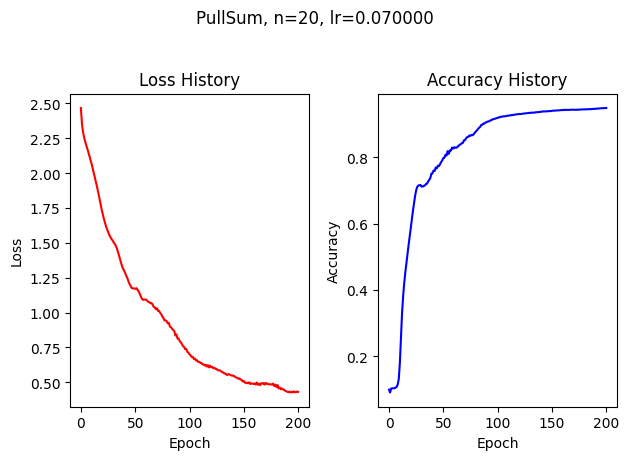

In [53]:
Sum_l2, Sum_a2 = train_PullSum(
    n=n,
    A=A,
    B=B,
    model_class=MNISTClassifier_4layer_2,
    seed_for_model=49,
    criterion_class=nn.CrossEntropyLoss,
    epochs=200,
    lr=3.5e-3,
    X_train_data=h_data,
    y_train_data=y_data,
    X_test_data=X_test,
    y_test_data=y_test,
    compute_accuracy=compute_accuracy_with_average_model,
    show_graph=True
)

Training Progress: 100%|██████████| 200/200 [02:13<00:00,  1.50it/s, accuracy=94.6400000000%, epoch=200, loss=0.4674812779]


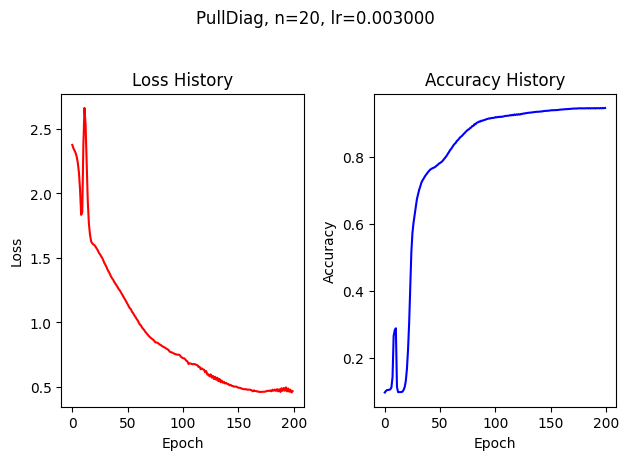

In [46]:
Diag_l1, Diag_a1 = train_PullDiag(
    n=n,
    A=A,
    model_class=MNISTClassifier_4layer_2,
    seed_for_model=49,
    criterion_class=nn.CrossEntropyLoss,
    epochs=200,
    lr=3e-3,
    X_train_data=h_data,
    y_train_data=y_data,
    X_test_data=X_test,
    y_test_data=y_test,
    compute_accuracy=compute_accuracy_with_average_model,
    show_graph=True
)

Training Progress: 100%|██████████| 200/200 [02:13<00:00,  1.49it/s, accuracy=96.1800000000%, epoch=200, loss=0.3295563236]


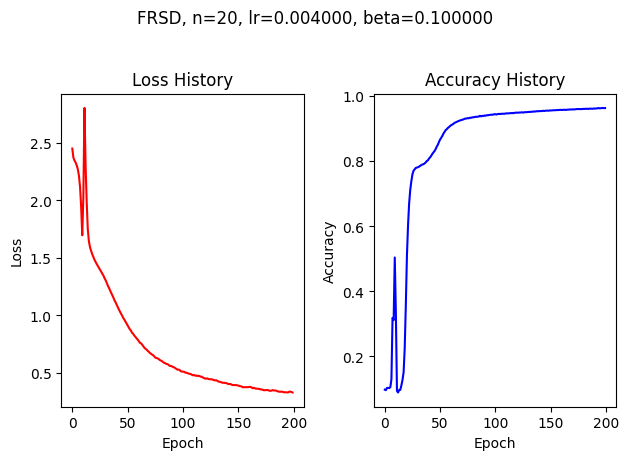

In [47]:
FRSD_l1, FRSD_a1 = train_FRSD(
    n=n,
    A=A,
    model_class=MNISTClassifier_4layer_2,
    seed_for_model=49,
    criterion_class=nn.CrossEntropyLoss,
    epochs=200,
    lr=4e-3,
    beta=0.1,
    X_train_data=h_data,
    y_train_data=y_data,
    X_test_data=X_test,
    y_test_data=y_test,
    compute_accuracy=compute_accuracy_with_average_model,
    show_graph=True
)

Training Progress: 100%|██████████| 200/200 [02:13<00:00,  1.49it/s, accuracy=69.6500000000%, epoch=200, loss=2.1319761753]


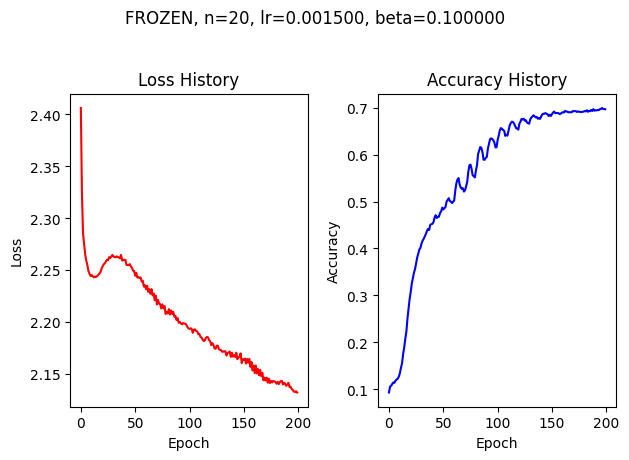

In [50]:
FROZEN_l1, FROZEN_a1 = train_FROZEN(
    n=n,
    A=A,
    model_class=MNISTClassifier_4layer_2,
    seed_for_model=49,
    criterion_class=nn.CrossEntropyLoss,
    epochs=200,
    lr=1.5e-3,
    beta=0.1,
    X_train_data=h_data,
    y_train_data=y_data,
    X_test_data=X_test,
    y_test_data=y_test,
    compute_accuracy=compute_accuracy_with_average_model,
    show_graph=True
)

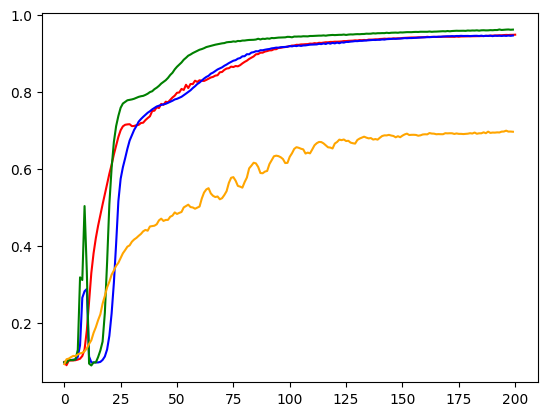

In [55]:
plt.plot(Sum_a2,color='r')
plt.plot(Diag_a1,color='b')
plt.plot(FRSD_a1,color='g')
plt.plot(FROZEN_a1,color='orange')
plt.show()

In [56]:
data = {
    'Sum_aa1': Sum_a2,
    'Diag_aa1': Diag_a1,
    'FRSD_aa1': FRSD_a1,
    'FROZEN_aa1': FROZEN_a1  # 确保长度一致
}
from itertools import zip_longest

# 创建 DataFrame
df = pd.DataFrame(zip_longest(*data.values(), fillvalue=0), columns=data.keys())

# 保存为 CSV 文件
df.to_csv('/root/GanLuo/PullSum_MNIST/code/神经网络实验/MNIST最终实验/实验结果保存/new/20节点, ring3, 小异质性.csv', index=False)

In [2]:
df = pd.read_csv("/root/GanLuo/PullSum_MNIST/code/神经网络实验/MNIST最终实验/实验结果保存/new/20节点, ring3, 小异质性.csv")

In [3]:
Sum_aa1=df['Sum_aa1']
Diag_aa1=df['Diag_aa1']
FRSD_aa1=df['FRSD_aa1']
FROZEN_aa1=df['FROZEN_aa1']

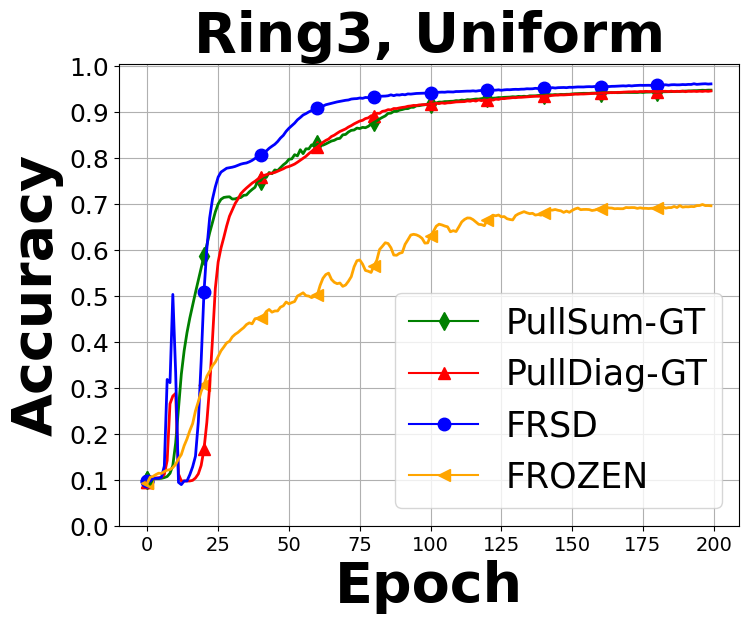

In [4]:
# plot the results
a=200
grads = [Sum_aa1[:a], Diag_aa1[:a], FRSD_aa1[:a], FROZEN_aa1[:a]]
legend = ['PullSum-GT', 'PullDiag-GT', 'FRSD', 'FROZEN']
title = "Ring3, Uniform"
save = '/root/GanLuo/PullSum_MNIST/code/神经网络实验/MNIST最终实验/图片/Ring_3, 20节点, 小异质性.pdf'
ylabel = 'Accuracy'

plt.rcParams['figure.figsize'] = 8, 6
plt.figure()
xlen = len(grads[0])
colors = ['green', 'red', 'blue', 'orange', 'purple', 'cyan']
markers = ['d', '^', 'o', '<', '*', 's']
idx_set = np.arange(0, xlen, xlen // 10)

for i in range(len(grads)):
    plt.plot(0, grads[i][0], color=colors[i], marker=markers[i], markersize=9)

for i in range(len(grads)):
    for idx in idx_set:
        plt.plot(idx, grads[i][idx], color=colors[i], marker=markers[i], markersize=9, linestyle='None')

for i in range(len(grads)):
    plt.plot(np.arange(xlen), grads[i], linewidth=2.0, color=colors[i])

plt.legend(legend, fontsize=25)
plt.xlabel('Epoch', fontsize=40, fontweight='bold')
plt.ylabel(ylabel, fontsize=40, fontweight='bold')
plt.title(title, fontsize=40, fontweight='bold') 
plt.grid(True)

# Set denser y-ticks
y_ticks = np.arange(0, 1.1, 0.1)  # Adjust this range and step as needed
plt.yticks(y_ticks, fontsize=18)

plt.xticks(fontsize=14)
plt.savefig(save, bbox_inches='tight')
plt.show()